In [ ]:
#!pip install tensorflow_hub tensorflow
#!pip install tensorflow-macos tensorflow-metal

In [55]:
import cv2
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python.client import device_lib
import os, re, json
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt

In [223]:
#tf.config.list_physical_devices('gpu')
#device_lib.list_local_devices()
tf.config.list_physical_devices()
tf.debugging.set_log_device_placement(True)

In [224]:
labels = {"1": "person", "2": "bicycle", "3": "car", "4": "motorcycle", "5": "airplane", "6": "bus", "7": "train", "8": "truck", "9": "boat", "10": "traffic light", "11": "fire hydrant", "13": "stop sign", "14": "parking meter", "15": "bench", "16": "bird", "17": "cat", "18": "dog", "19": "horse", "20": "sheep", "21": "cow", "22": "elephant", "23": "bear", "24": "zebra", "25": "giraffe", "27": "backpack", "28": "umbrella", "31": "handbag", "32": "tie", "33": "suitcase", "34": "frisbee", "35": "skis", "36": "snowboard", "37": "sports ball", "38": "kite", "39": "baseball bat", "40": "baseball glove", "41": "skateboard", "42": "surfboard", "43": "tennis racket", "44": "bottle", "46": "wine glass", "47": "cup", "48": "fork", "49": "knife", "50": "spoon", "51": "bowl", "52": "banana", "53": "apple", "54": "sandwich", "55": "orange", "56": "broccoli", "57": "carrot", "58": "hot dog", "59": "pizza", "60": "donut", "61": "cake", "62": "chair", "63": "couch", "64": "potted plant", "65": "bed", "67": "dining table", "70": "toilet", "72": "tv", "73": "laptop", "74": "mouse", "75": "remote", "76": "keyboard", "77": "cell phone", "78": "microwave", "79": "oven", "80": "toaster", "81": "sink", "82": "refrigerator", "84": "book", "85": "clock", "86": "vase", "87": "scissors", "88": "teddy bear", "89": "hair drier", "90": "toothbrush"}

In [225]:
DATA_PATH = os.path.abspath(os.path.join("../../..", "Seafile", "Detecting-Objects", "DataCollection"))
IMAGE_PATH = os.path.join(DATA_PATH, "images")
LABEL_PATH = os.path.join(DATA_PATH, "labels")

TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')
VAL_PATH = os.path.join(DATA_PATH, 'val')

In [227]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = [int(coord) for coord in bbox]
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img.copy(), (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, class_names):
    img = image.copy()
    for bbox, class_name in zip(bboxes, class_names):
        img = visualize_bbox(img, bbox, class_name)
    plt.imshow(img)
    plt.show()

In [238]:
def load_image(path):
    byte_img = cv2.imread(path)
    byte_img = cv2.resize(byte_img, (640, 640))
    rgb = cv2.cvtColor(byte_img, cv2.COLOR_BGR2RGB)
    
    return tf.convert_to_tensor(rgb, dtype=tf.uint8)

In [244]:
image = load_image(os.path.join(VAL_PATH, 'e302f7ca-7089-11ed-b2e3-1b1b14efb1a9.png'))
image = image[:,:,:3] # only needed if we have PNGs with an additional alpha channel

#image_tensor = image / 255
#image_tensor = tf.expand_dims(image_tensor, axis = 0)
image_tensor = tf.squeeze(image_tensor, axis = 0)
image_tensor = tf.cast(image_tensor, tf.uint8)

tf.shape(image_tensor)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Squeeze in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0


<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  1, 640, 640,   3], dtype=int32)>

In [158]:
detector = hub.load("https://tfhub.dev/tensorflow/efficientdet/d0/1")

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

In [245]:
result = detector(image_tensor)

Executing op __inference_restored_function_body_341845 in device /job:localhost/replica:0/task:0/device:GPU:0


In [246]:
boxes, scores, classes, num_detections  = result['detection_boxes'], result['detection_scores'], result['detection_classes'], result['num_detections']

In [247]:
pred_labels = classes.numpy().astype('int')[0]
pred_labels = [labels[str(i)] for i in pred_labels]
pred_boxes = boxes.numpy()[0]
pred_scores = scores.numpy()[0]

0.07270916 refrigerator
0.06281308 toilet
0.05780303 potted plant
0.056622535 vase
0.056380283 cat
0.055121046 tv
0.054949068 elephant
0.05337982 person
0.05297137 bottle
0.051007606 stop sign
0.05059687 clock
0.04863071 cup
0.045193993 parking meter
0.041237988 fire hydrant
0.03656205 bird
0.03482053 suitcase
0.033692803 traffic light
0.03362632 bowl
0.032676004 microwave
0.031679217 sink
0.031224733 train
0.030824127 book
0.030821543 umbrella
0.030379014 hair drier
0.029123839 chair
0.028807735 keyboard
0.028409155 car
0.028285064 oven
0.0280055 cake
0.02759828 teddy bear
0.026157197 person
0.025831632 refrigerator
0.025699627 dining table
0.025537694 handbag
0.025468957 bottle
0.025047624 truck
0.024615018 orange
0.024577916 person
0.02446145 cat
0.024350056 scissors
0.024045281 apple
0.024040192 laptop
0.023970075 potted plant
0.023223668 bed
0.023192191 bottle
0.02211363 bicycle
0.022019196 dog
0.02129257 parking meter
0.020911751 toilet
0.020726848 toaster
0.020708542 potted plan

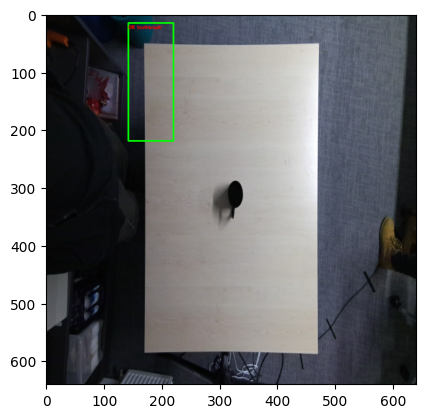

In [248]:
for score, (ymin, xmin, ymax, xmax), label in zip(pred_scores, pred_boxes, pred_labels):
    print(score, label)
    xmin = int(xmin * 224)
    ymin = int(ymin * 224)
    xmax = int(xmax * 224)
    ymax = int(ymax * 224)
    img_boxes = cv2.rectangle(image.numpy().copy(), (xmin, ymin), (xmax,ymax), (0,255,0), 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_boxes, label, (xmin + 15, ymin+10), font, 0.25, (255, 0, 0), 1, cv2.LINE_AA )
    score_txt = f"{100 * round(score)}%"
    cv2.putText(img_boxes, score_txt, (xmin, ymin+10), font, 0.25, (255, 0, 0), 1, cv2.LINE_AA )
    
plt.imshow(img_boxes)

In [53]:
import tensorflow as tf

def load_image(path):
    byte_img = tf.io.read_file(path)
    
    return tf.io.decode_jpeg(byte_img)

def load_images(path):
    images = tf.data.Dataset.list_files(path, shuffle=False)
    images = images.map(load_image)

    return images.map(lambda x: x/255)


def load_label(path):
    with open(os.path.join(VAL_PATH, 'aug', path), "r") as file:
        annotation = json.load(file)
        
    return [annotation['class']], annotation['bboxes']


def load_labels(path):
    annotations = tf.data.Dataset.list_files(path, shuffle=False)

    return annotations.map(lambda x: tf.py_function(load_label, [x], [tf.uint8, tf.float16]))

In [178]:
SEAFILE_PATH = os.path.abspath(os.path.join("../../..", "Seafile", "Detecting-Objects", "DataCollection"))

image_names = [file for file in os.listdir(os.path.join(VAL_PATH, 'aug')) if re.match(r'.*\.(jpg|jpeg|png)', file)]
annotation_names = [file for file in os.listdir(os.path.join(VAL_PATH, 'aug')) if re.match(r'.*\.json', file)]

annotations = list(map(load_label, annotation_names))
images = list(load_images(f"{os.path.join(VAL_PATH, 'aug/')}*.jpg"))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatchingFiles in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Greater in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReduceJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0

TypeError: in user code:

    File "/var/folders/h5/hp2v99qn73g0fwqq5k_93vlr0000gn/T/ipykernel_99773/518833006.py", line 2, in load_image  *
        byte_img = cv2.imread(path)

    TypeError: Can't convert object to 'str' for 'filename'


In [122]:
import tensorflow as tf
from tensorflow.keras import layers
import cv2

# Load the pre-trained model
#model = tf.keras.models.load_model(os.path.join('models', 'efficientdet_d1_coco17_tpu-32', 'saved_model', 'saved_model.pb'))
model = tf.saved_model.load(os.path.join('models', 'efficientdet_d1_coco17_tpu-32', 'saved_model'))

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

2022-12-07 08:39:32.747378: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:32.747392: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:32.771710: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:32.771722: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:32.773229: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:32.773240: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0


Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

2022-12-07 08:39:32.956325: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:32.956339: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:32.958987: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:32.958998: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.126226: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.126243: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.127611: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /j

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

2022-12-07 08:39:33.158154: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.158166: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.166611: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.166623: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.170753: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.170765: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.172184: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /j

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

2022-12-07 08:39:33.377698: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.377713: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.382501: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.382514: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.432063: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.432077: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.443903: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /j

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

2022-12-07 08:39:33.579826: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.579842: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.584806: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.584819: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.586416: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.586428: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:33.618476: I tensorflow/core/common_runtime/placer.cc:114] input: (_Arg): /job:localhost/


systemMemory: 32.00 GB
maxCacheSize: 1.99 GB

input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
pattern: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
MatchingFiles: (MatchingFiles): /job:localhost/replica:0/task:0/device:CPU:0
filenames_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
Shape: (Shape): /job:localhost/replica:0/task:0/device:CPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
begin: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
end: (_Arg): /job:lo

2022-12-07 08:39:40.069132: I tensorflow/core/common_runtime/placer.cc:114] prefix: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-12-07 08:39:40.069148: I tensorflow/core/common_runtime/placer.cc:114] tensor__names: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-12-07 08:39:40.069152: I tensorflow/core/common_runtime/placer.cc:114] shape__and__slices: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-12-07 08:39:40.069158: I tensorflow/core/common_runtime/placer.cc:114] RestoreV2: (RestoreV2): /job:localhost/replica:0/task:0/device:CPU:0
2022-12-07 08:39:40.069162: I tensorflow/core/common_runtime/placer.cc:114] tensors_0_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2022-12-07 08:39:40.069165: I tensorflow/core/common_runtime/placer.cc:114] tensors_1_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2022-12-07 08:39:40.069168: I tensorflow/core/common_runtime/placer.cc:114] tensors_2_RetVal: (_Retval): /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

2022-12-07 08:39:41.212942: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.212955: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.212960: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.216524: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.216536: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.216561: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.219986: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

2022-12-07 08:39:41.473249: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.473263: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.473270: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.475385: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.475397: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.475403: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.477787: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0


2022-12-07 08:39:41.688778: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.688791: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.688798: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.720250: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.720265: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.720272: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.722477: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableO

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableO

value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/

resource: (_Arg): /job:localhost/replica:0/task:Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/

2022-12-07 08:39:41.877896: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.877911: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.877924: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.884065: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.884081: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.884088: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:41.891867: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableO

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableO

2022-12-07 08:39:42.125163: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.125222: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.125236: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.180943: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.180967: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.180976: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.280188: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

2022-12-07 08:39:42.347102: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.347124: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.347133: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.399913: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.399931: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.399939: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

2022-12-07 08:39:42.593738: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.593755: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.593764: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.609616: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.609633: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.609641: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2022-12-07 08:39:42.621441: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in dev

"\n# Create a TensorFlow dataset with the preprocessed images and labels\ndataset = tf.data.Dataset.from_tensor_slices((images, (class_labels, bbox_labels)))\n\n# Create batches of images and labels\ndataset = dataset.batch(BATCH_SIZE)\n\n# Evaluate the model on the preprocessed images and labels\nloss, (class_accuracy, bbox_accuracy) = model.evaluate(dataset)\n\n# Print the loss and accuracy\nprint('Loss:', loss)\nprint('Class accuracy:', class_accuracy)\nprint('Bounding box accuracy:', bbox_accuracy)\n"

In [133]:
predictor = model.signatures['serving_default']

print(images[10])
'''
# Read in the images and labels
images = []
class_labels = []
bbox_labels = []
for filename, (class_label, bbox_label) in zip(image_names, annotations):
    image = cv2.imread(os.path.join(VAL_PATH, 'aug', filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.normalize(image, None, 0.0, 1.0, cv2.NORM_MINMAX)    
    images.append(image)
    class_labels.append(class_label)
    bbox_labels.append(bbox_label)
    


# Create a TensorFlow dataset with the preprocessed images and labels
dataset = tf.data.Dataset.from_tensor_slices((images, (class_labels, bbox_labels)))

# Create batches of images and labels
dataset = dataset.batch(BATCH_SIZE)

# Evaluate the model on the preprocessed images and labels
loss, (class_accuracy, bbox_accuracy) = model.evaluate(dataset)

# Print the loss and accuracy
print('Loss:', loss)
print('Class accuracy:', class_accuracy)
print('Bounding box accuracy:', bbox_accuracy)
'''

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


"\n# Read in the images and labels\nimages = []\nclass_labels = []\nbbox_labels = []\nfor filename, (class_label, bbox_label) in zip(image_names, annotations):\n    image = cv2.imread(os.path.join(VAL_PATH, 'aug', filename))\n    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n    image = cv2.normalize(image, None, 0.0, 1.0, cv2.NORM_MINMAX)    \n    images.append(image)\n    class_labels.append(class_label)\n    bbox_labels.append(bbox_label)\n    \n\n\n# Create a TensorFlow dataset with the preprocessed images and labels\ndataset = tf.data.Dataset.from_tensor_slices((images, (class_labels, bbox_labels)))\n\n# Create batches of images and labels\ndataset = dataset.batch(BATCH_SIZE)\n\n# Evaluate the model on the preprocessed images and labels\nloss, (class_accuracy, bbox_accuracy) = model.evaluate(dataset)\n\n# Print the loss and accuracy\nprint('Loss:', loss)\nprint('Class accuracy:', class_accuracy)\nprint('Bounding box accuracy:', bbox_accuracy)\n"